<a href="https://colab.research.google.com/github/aspenjkmorgan/Radiative_Equilibrium_Model/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate HW1: Radiative equilibrium model
## by Aspen Morgan

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
!pip install metpy
from metpy import plots

In [54]:
class REM:

  # INPUTS: total time of simulation, time step, mass at surface, pressure at surface, pressure step,
  #   beta (SW absorption), alpha (surf reflectance), initial atmos temp, and r=frac decrease in sw absorption
  # OUTPUTS: nothing
  # SIDE EFFECTS: initializes arrays and defines constants
  def __init__(self, tot_time, del_t = 3600, m_sur=5000/9.8, p_sur=100_000.0, del_p=5000.0, beta=0.0, alpha=0.3, T_i=50.0, r=0.5):
    # Time constants
    self.tot_time = tot_time # simulation time in seconds
    self.del_t = del_t # time step in seconds

    # Determine number of atmospheric layers and levels
    self.N = int(p_sur/del_p) # get number of atmospheric layers and levels

    # For levels:
    self.S_0 = 1363.0 # W/m^2 (Solar irradiance)
    self.ps = 1.0*np.arange(0, p_sur+del_p, del_p) # pressures for levels

    # For layers
    self.Cps = 1005*np.ones_like(self.ps) # Specific heat for air (J/K/kg)
    self.epsilons = np.ones_like(self.ps) # LW emissivities
    self.mid_ps = 1.0*np.zeros_like(self.ps) # pressures for layers
    for n in range(self.N): # N=0 to N=19
      mid_p = (self.ps[n] + self.ps[n+1])/2
      self.mid_ps[n] = mid_p
      if mid_p  > 80_000:
        self.epsilons[n] = 0.3
      elif (mid_p > 40_000) & (mid_p <= 80_000):
        self.epsilons[n] = 0.2
      else:
        self.epsilons[n] = 0.1
    self.mid_ps[-1] = self.mid_ps[-2] + 5000
    self.sw_abs = beta * np.ones_like(self.ps) # SW absorptivities
    for n in range(1, self.N): # N=1 to N=19
        self.sw_abs[n] = self.sw_abs[n-1]*r
    self.sw_abs[-2] = alpha # surface albedo, N=20
    self.sw_abs[-1] = 0 # N=21
    self.ms = m_sur*np.ones_like(self.ps) # Masses
    self.Ts = T_i*np.ones_like(self.ps) # Temperatures


  # INPUT: none (everything initialized before)
  # OUTPUT: array of temperatures by time step and then by pressure height
  def run_sim(self):
    sigma = 5.67e-8 # in W/m^2/K^4
    all_Ts = 1.0*np.zeros((int(self.tot_time/self.del_t)+1, self.N+1))
    all_Ts[0] = self.Ts

    # loop through times
    for t in np.arange(0, self.tot_time + self.del_t, self.del_t):

      # empty arrays to hold level fluxes
      LW_downs = 1.0*np.zeros(self.N+2) # 22 levels [0, 21]
      LW_ups = 1.0*np.zeros_like(LW_downs)
      SW_downs = 1.0*np.zeros_like(LW_downs)

      # get upward LW flux
      LW_ups[-1] = 0 # K=21
      LW_ups[-2] = sigma*(self.Ts[-1]**4) # K=20
      for n in range(self.N-1, -1, -1): # K=19 to K=0
        LW_ups[n] = (1-self.epsilons[n])*LW_ups[n+1] + self.epsilons[n]*sigma*(self.Ts[n]**4)

      # get downward LW flux
      LW_downs[0] = 0 # K=0
      LW_downs[1] = self.epsilons[0]*sigma*(self.Ts[0]**4) # K=1
      for n in range(2, self.N+1): # K=2 to K=20
        LW_downs[n] = (1-self.epsilons[n-1])*LW_downs[n-1] + self.epsilons[n-1]*sigma*(self.Ts[n-1]**4)
      LW_downs[-1] = 0 # K=21

      # get downward SW flux
      SW_downs[0] = self.S_0/4 # K=0
      for n in range(1, self.N+1): # K=1 to K=20
          SW_downs[n] = (1-self.sw_abs[n-1])*SW_downs[n-1]
      SW_downs[-1] = 0 # K=21

      # convert levels to layers
      Flw_up = 0.0*np.zeros((self.N+1)) # 21 layers (20 atmos, 1 ground)
      Flw_down = 0.0*np.zeros_like(Flw_up)
      Fsw = 0.0*np.zeros_like(Flw_up)

      for n in range(self.N+1): # N=0 to N=20
        Fsw[n] = SW_downs[n] - SW_downs[n+1]
        Flw_down[n] = LW_downs[n] - LW_downs[n+1]

      for n in range(self.N, -1, -1): # N=20 to N=0
        Flw_up[n] = LW_ups[n+1] - LW_ups[n]

      # get flux convergence for each layer
      del_F = Flw_up + Flw_down + Fsw

      # update temperatures and add to summary array
      self.Ts = self.Ts + self.del_t*(del_F/(self.ms*self.Cps))
      all_Ts[int(t/self.del_t)] = self.Ts

    return all_Ts

## Part 1) No ozone (B=0)

In [55]:
two_weeks_sim = REM(tot_time=14*24*3600)
Ts_two_weeks = two_weeks_sim.run_sim()

In [56]:
one_month_sim = REM(tot_time=30*24*3600)
Ts_one_month = one_month_sim.run_sim()

In [57]:
six_months_sim = REM(tot_time=6*30*24*3600)
Ts_six_months = six_months_sim.run_sim()

In [58]:
one_year_sim = REM(tot_time=365*24*3600)
Ts_one_year = one_year_sim.run_sim()

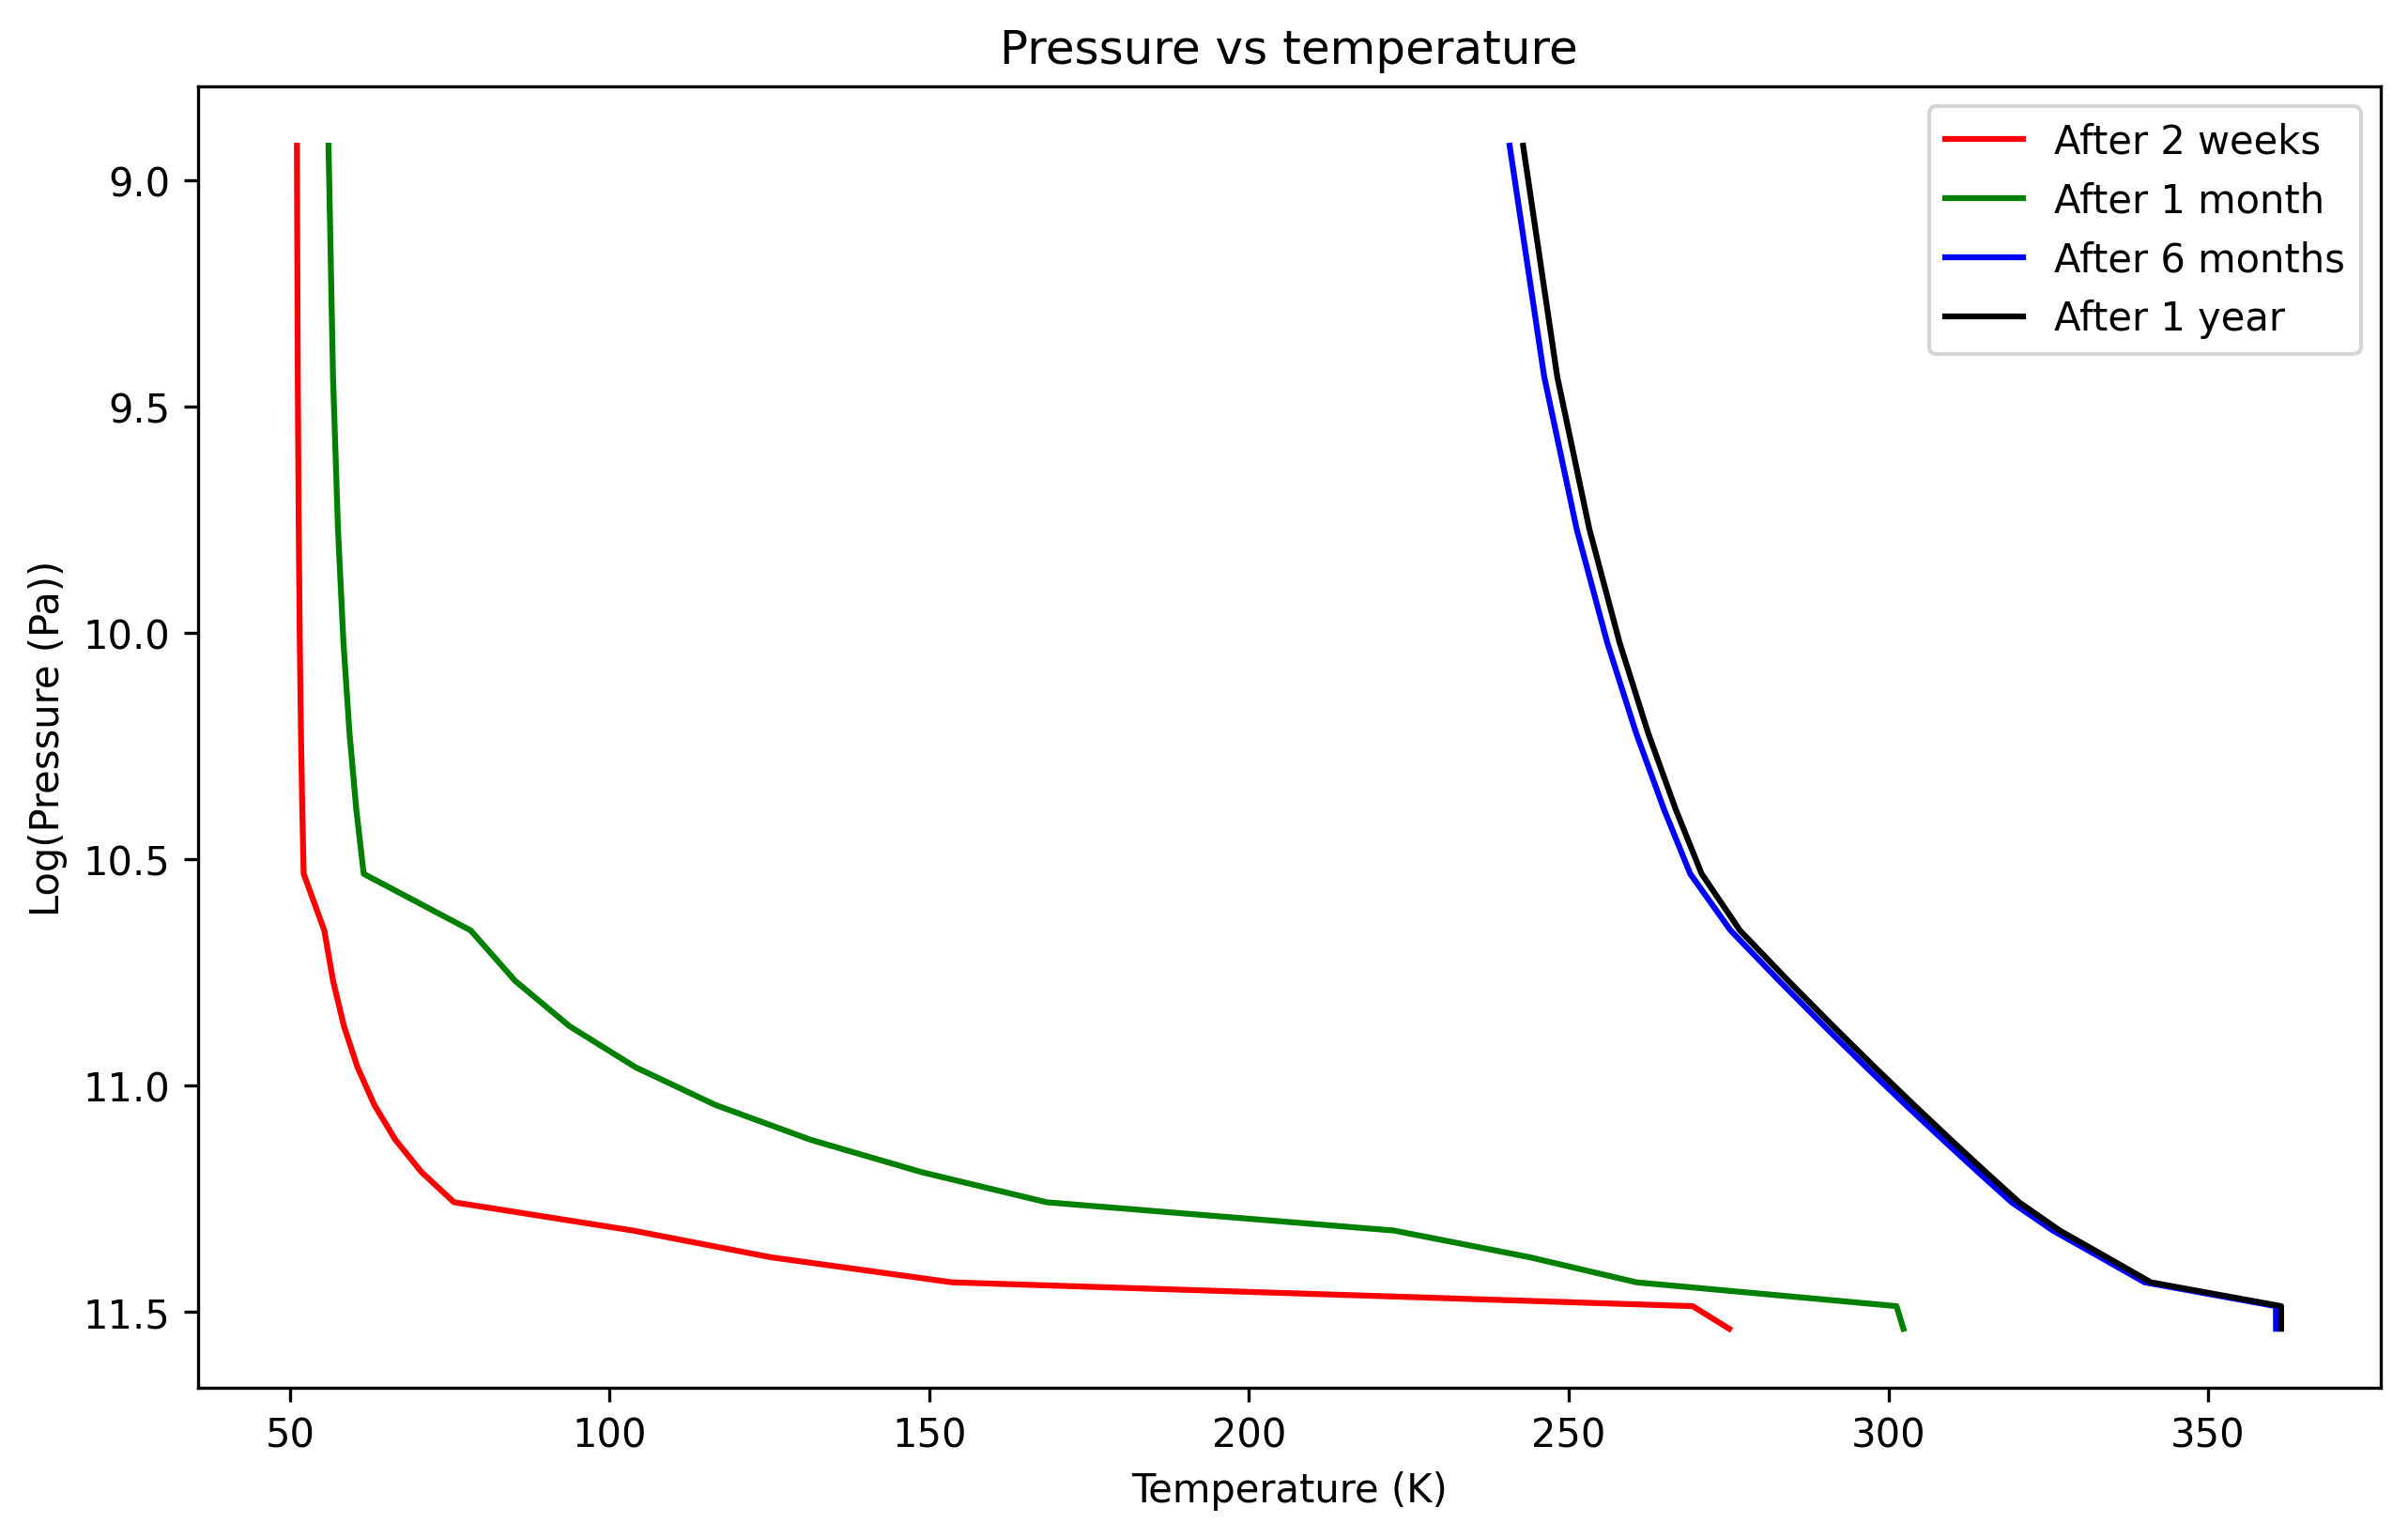

In [78]:
# plot vertical profile of temperature vs pressure height
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=300)
ax.plot(Ts_two_weeks[-1][1:], np.log(two_weeks_sim.mid_ps[1:]), label='After 2 weeks', c='r')
ax.plot(Ts_one_month[-1][1:], np.log(one_month_sim.mid_ps[1:]), label='After 1 month', c='g')
ax.plot(Ts_six_months[-1][1:], np.log(six_months_sim.mid_ps[1:]), label='After 6 months', c='b')
ax.plot(Ts_one_year[-1][1:], np.log(one_year_sim.mid_ps[1:]), label='After 1 year', c='k')
ax.plot()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Log(Pressure (Pa))')
ax.legend()
ax.invert_yaxis()
ax.set_title('Pressure vs temperature');
fig.savefig('p_v_t_no_ozone.png')

In [60]:
# convert pressure to z coords
dry_air_R = 287
densities = one_year_sim.mid_ps/(dry_air_R*Ts_one_year[-1])
dzs = 5000/(9.8*densities)
zs = np.flip(np.cumsum(np.flip(dzs)))

In [61]:
# get moist and dry lapse rate lines
x = Ts_one_year[-1][1:]
moist_line_alt = -(1000/6.5)*x + (1000/6.5)*Ts_one_year[-1][-1]
dry_line_alt = -(one_year_sim.Cps[0]/9.8)*x + (one_year_sim.Cps[0]/9.8)*Ts_one_year[-1][-1]

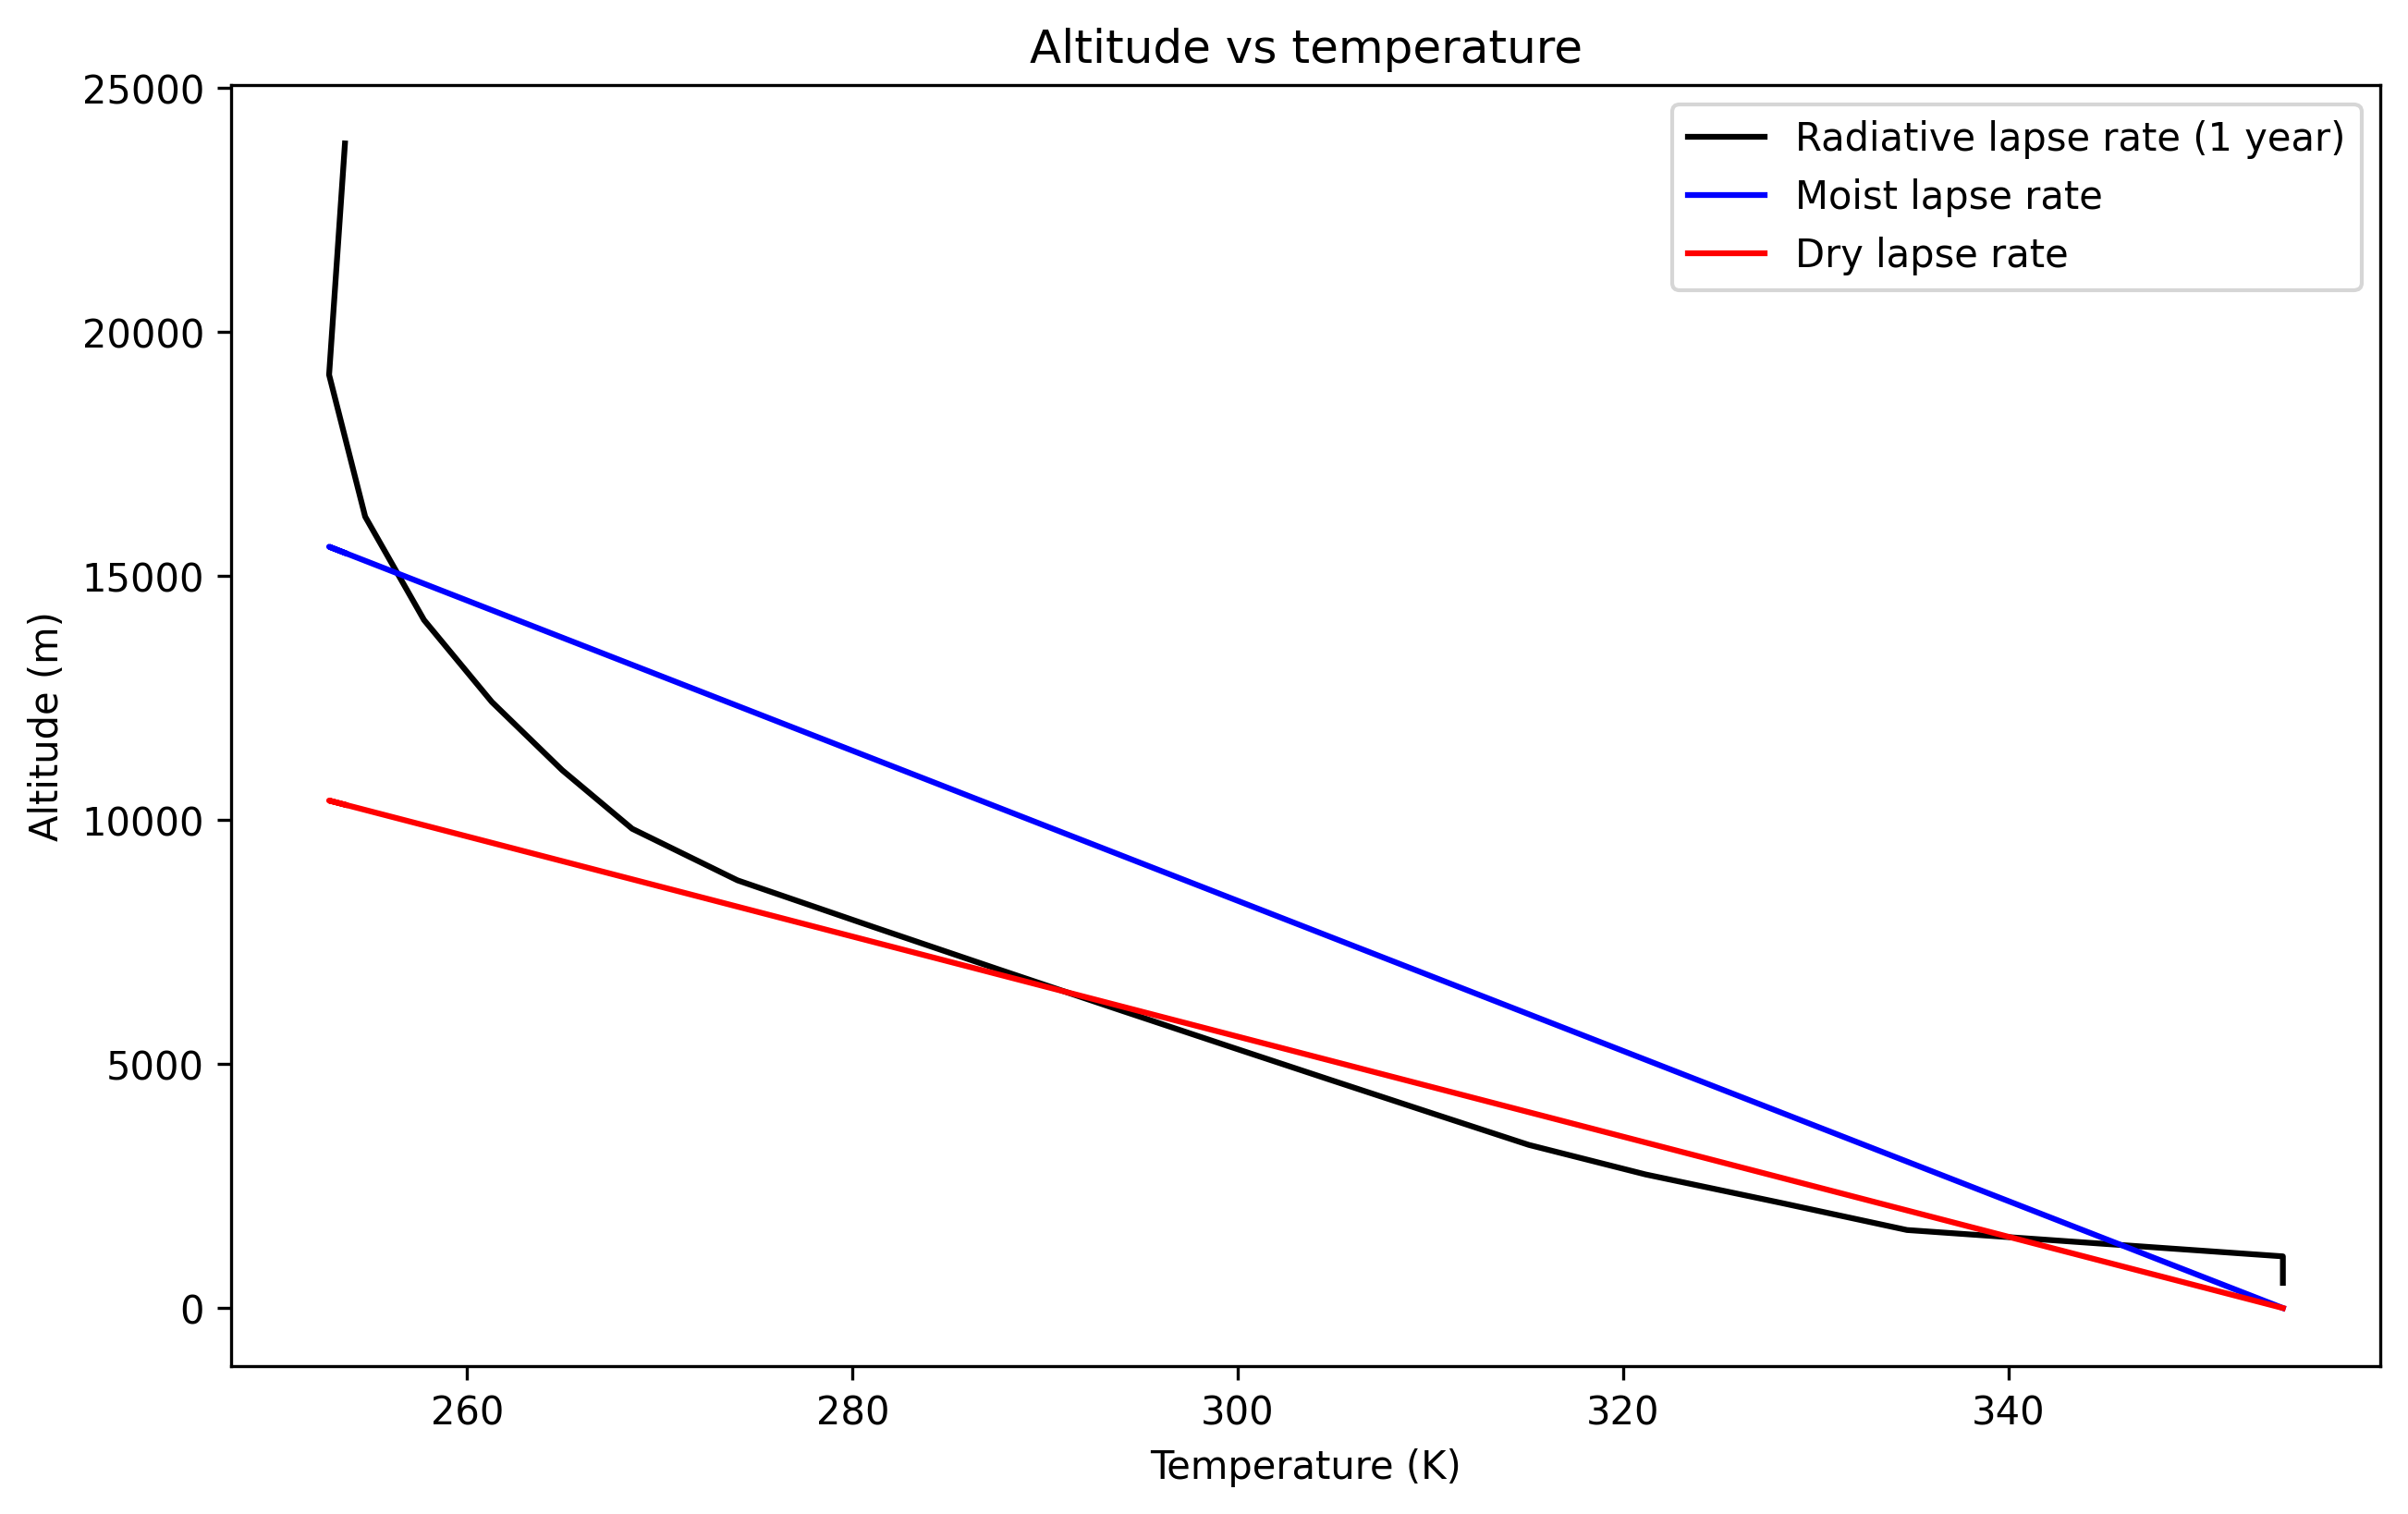

In [79]:
# plot vertical profile of temperature vs height
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
ax.plot(x, zs[1:], label='Radiative lapse rate (1 year)', c='k')
ax.plot(x, moist_line_alt, c='b', label='Moist lapse rate')
ax.plot(x, dry_line_alt, c='r', label='Dry lapse rate')
ax.plot()
ax.legend()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Altitude (m)')
ax.set_title('Altitude vs temperature');
fig.savefig('t_v_z_no_ozone.png')

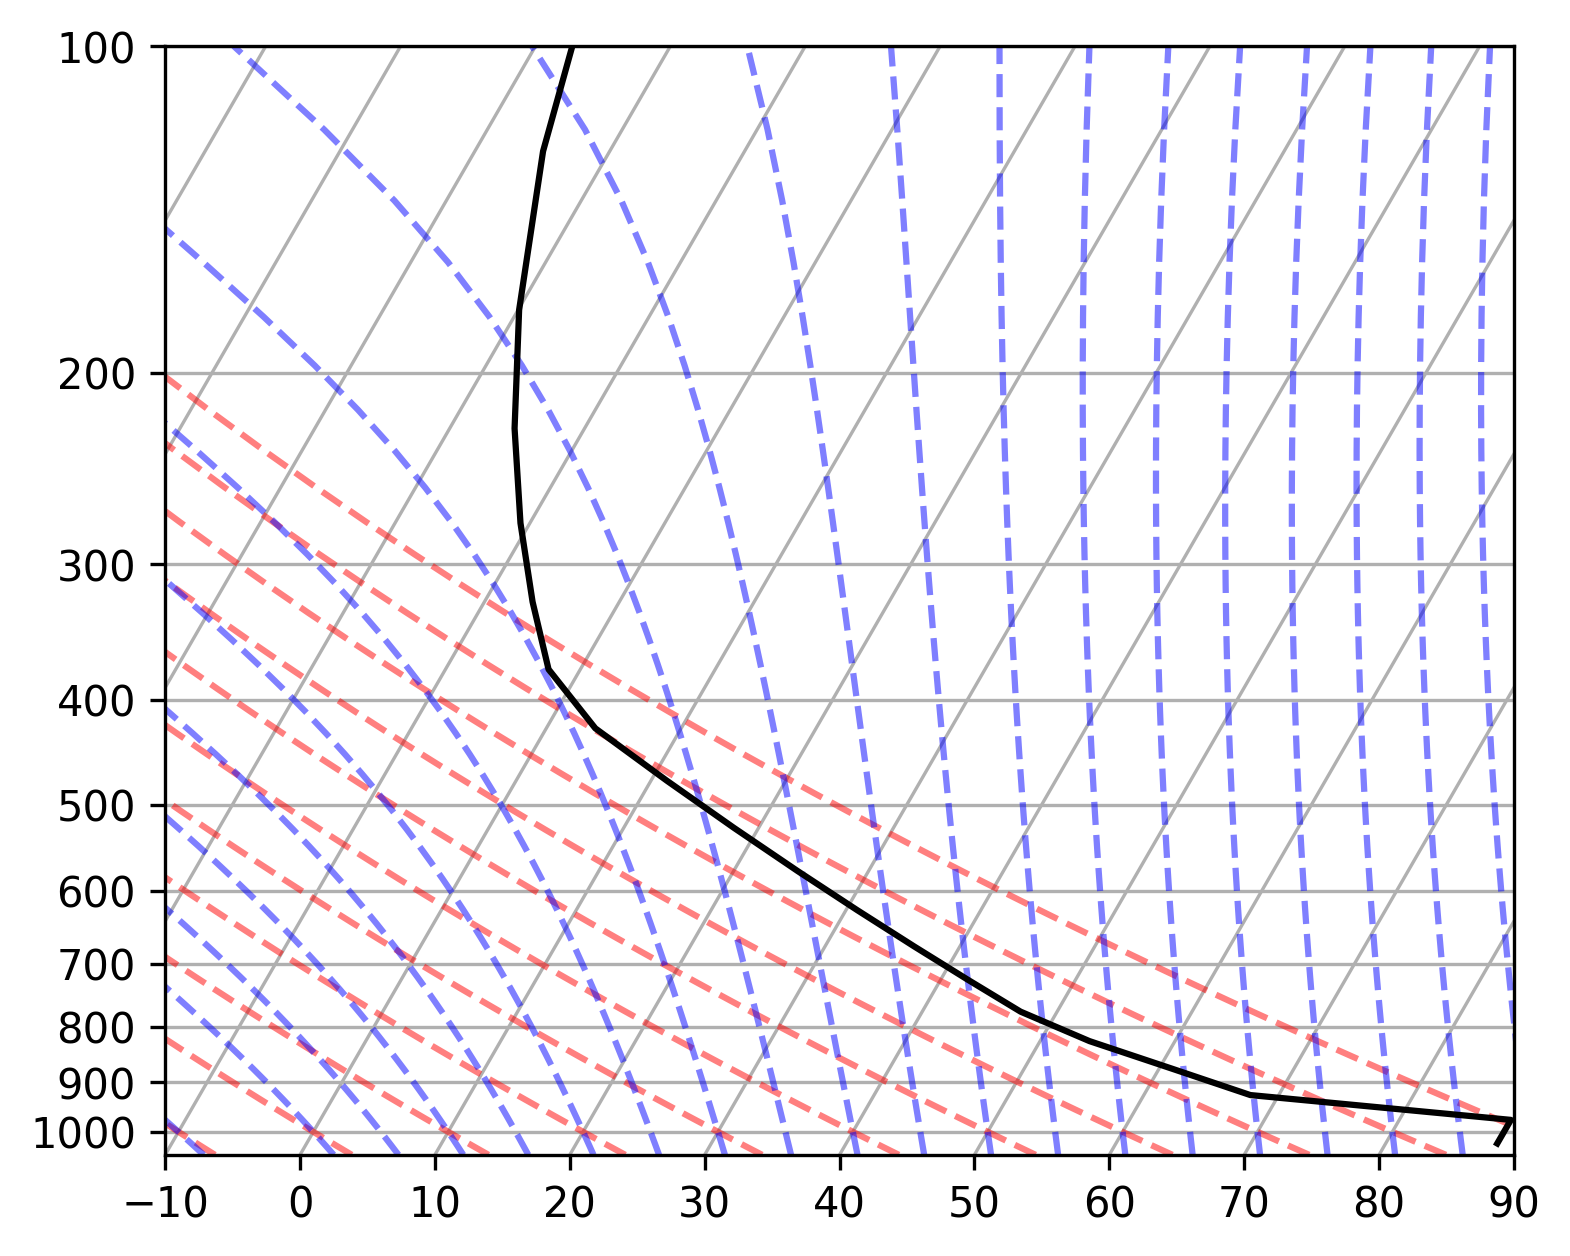

In [80]:
# skew t
fig = plt.figure(dpi=300)
skew = plots.SkewT(fig)
skew.ax.set_xlim(-10, 90)
skew.plot(one_year_sim.mid_ps/100, Ts_one_year[-1]-273.15, 'k')
skew.plot_dry_adiabats()
skew.plot_moist_adiabats();
fig.savefig('skew_t_no_ozone.png')

###**Analysis of results:**
Based on the skew-t, the radiative equilibrium lapse rate indicates absolute instability up to 750hPa, conditional instability between roughly 750hPa and 380hPa, and absolute stability above 380hPa.

## Part 2) Ozone

In [64]:
two_weeks_sim_ozone = REM(tot_time=14*24*3600, beta=0.05)
Ts_two_weeks_ozone = two_weeks_sim_ozone.run_sim()

In [65]:
one_month_sim_ozone = REM(tot_time=30*24*3600, beta=0.05)
Ts_one_month_ozone = one_month_sim_ozone.run_sim()

In [66]:
six_months_sim_ozone = REM(tot_time=6*30*24*3600, beta=0.05)
Ts_six_months_ozone = six_months_sim_ozone.run_sim()

In [67]:
one_year_sim_ozone = REM(tot_time=365*24*3600, beta=0.05)
Ts_one_year_ozone = six_months_sim_ozone.run_sim()

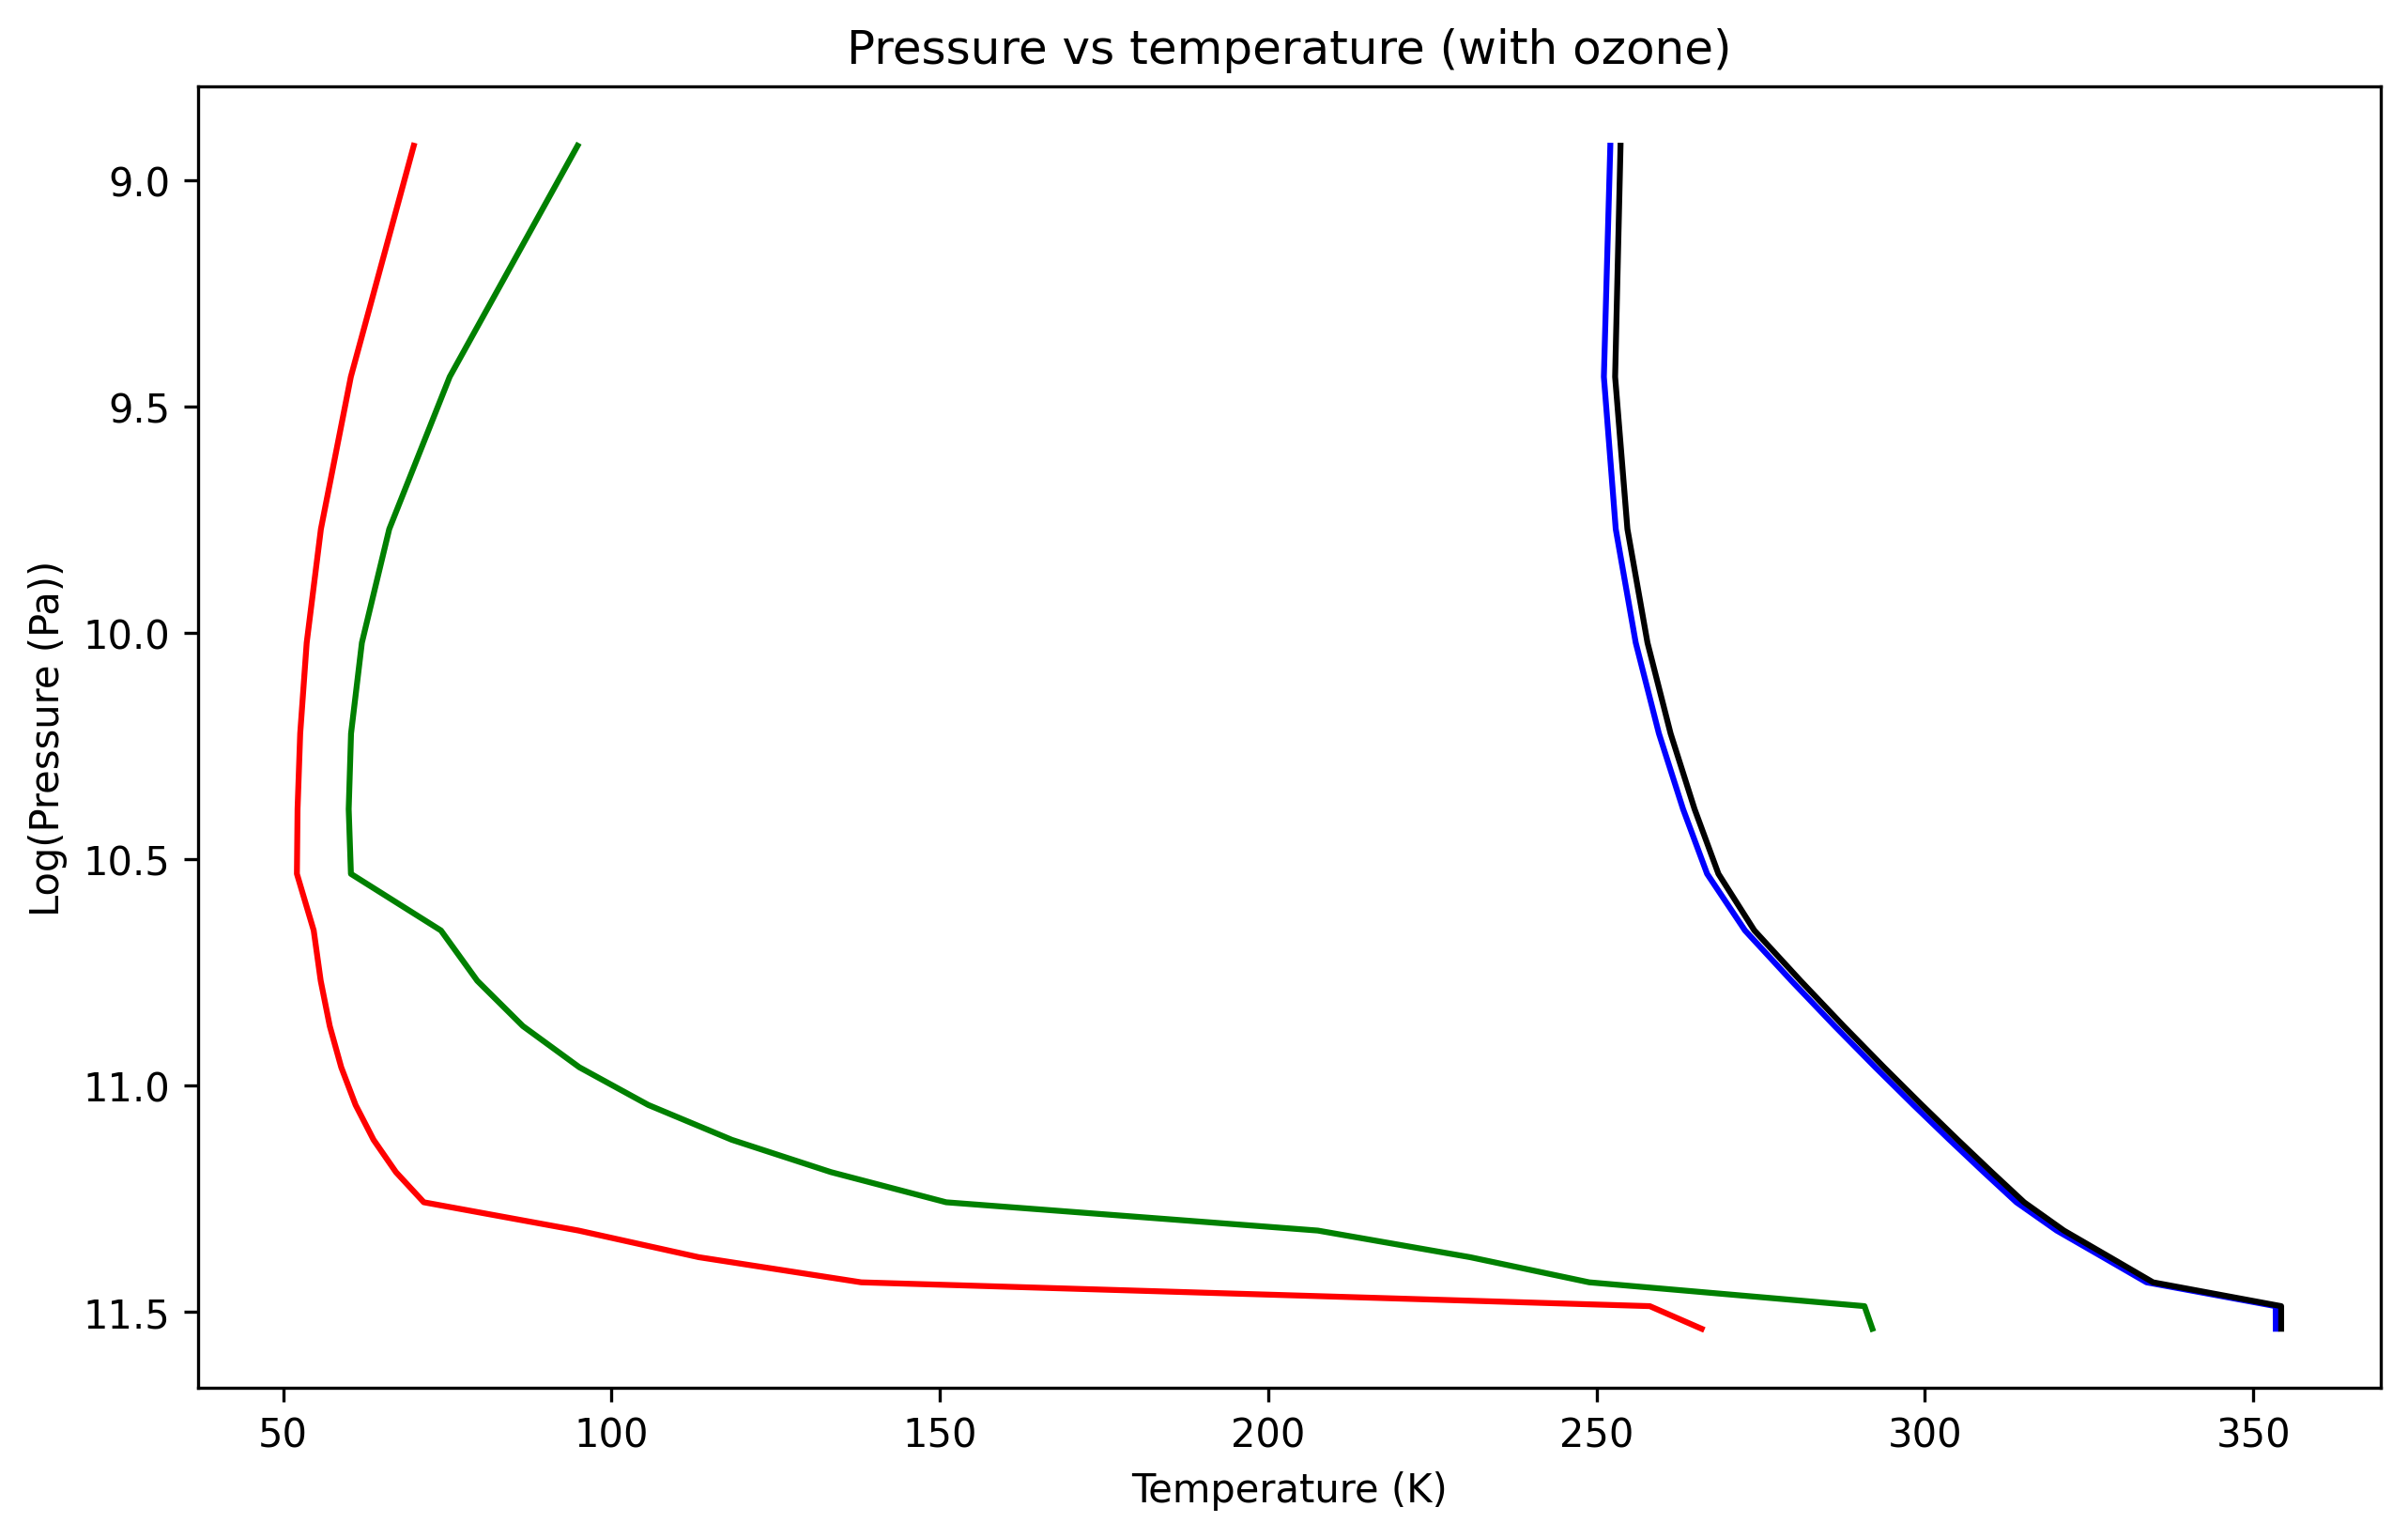

In [82]:
# plot vertical profile of temperature vs pressure height
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
ax.plot(Ts_two_weeks_ozone[-1][1:], np.log(two_weeks_sim_ozone.mid_ps[1:]), label='After 2 weeks', c='r')
ax.plot(Ts_one_month_ozone[-1][1:], np.log(one_month_sim_ozone.mid_ps[1:]), label='After 1 month', c='g')
ax.plot(Ts_six_months_ozone[-1][1:], np.log(six_months_sim_ozone.mid_ps[1:]), label='After 6 months', c='b')
ax.plot(Ts_one_year_ozone[-1][1:], np.log(one_year_sim_ozone.mid_ps[1:]), label='After 1 year', c='k')
ax.plot()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Log(Pressure (Pa))')
ax.invert_yaxis()
ax.set_title('Pressure vs temperature (with ozone)');
fig.savefig('p_v_t_with_ozone.png')

In [70]:
# convert pressure to height assuming constant density
dry_air_R = 287
densities = one_year_sim_ozone.mid_ps/(dry_air_R*Ts_one_year_ozone[-1])
dzs_ozone = 5000/(9.8*densities)
zs_ozone = np.flip(np.cumsum(np.flip(dzs)))

In [71]:
# get moist and dry lapse rate lines
x = Ts_one_year_ozone[-1][1:]
moist_line_alt = -(1000/6.5)*x + (1000/6.5)*Ts_one_year_ozone[-1][-1]
dry_line_alt = -(one_year_sim_ozone.Cps[0]/9.8)*x + (one_year_sim_ozone.Cps[0]/9.8)*Ts_one_year_ozone[-1][-1]

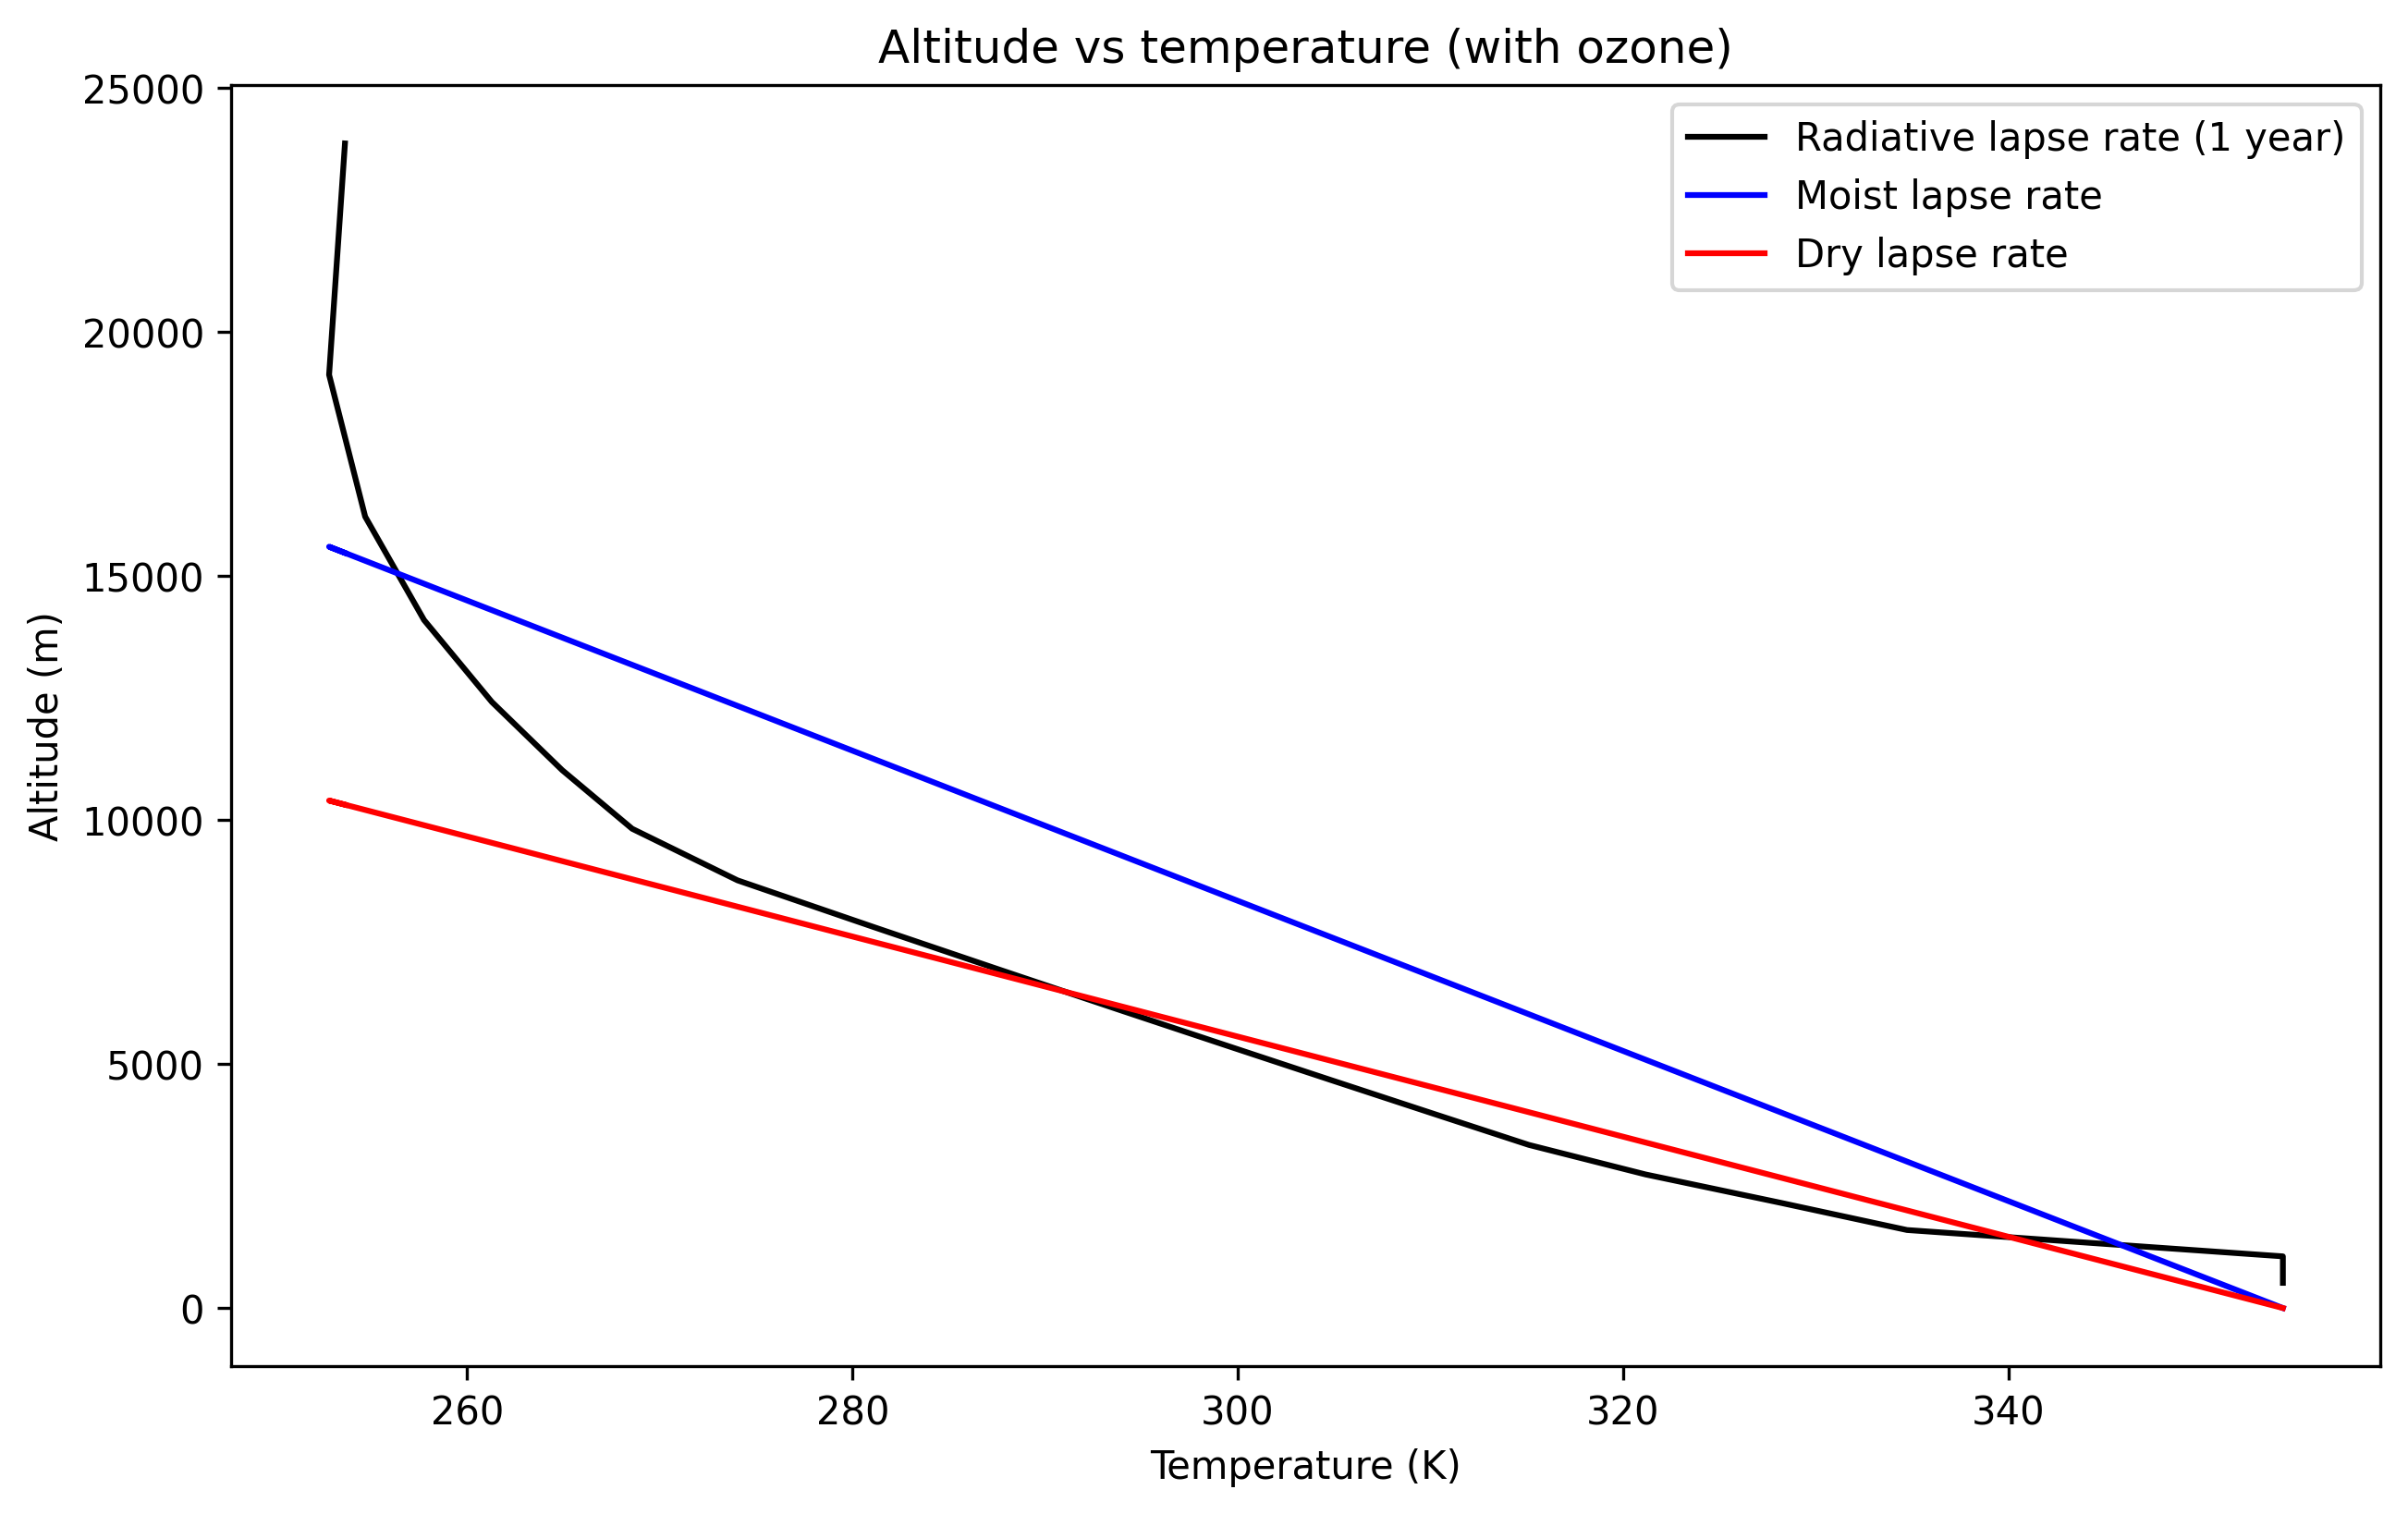

In [83]:
# plot vertical profile of temperature vs height
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
ax.plot(x, zs_ozone[1:], label='Radiative lapse rate (1 year)', c='k')
ax.plot(x, moist_line_alt, c='b', label='Moist lapse rate')
ax.plot(x, dry_line_alt, c='r', label='Dry lapse rate')
ax.plot()
ax.legend()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Altitude (m)')
ax.set_title('Altitude vs temperature (with ozone)');
fig.savefig('t_v_z_with_ozone.png')

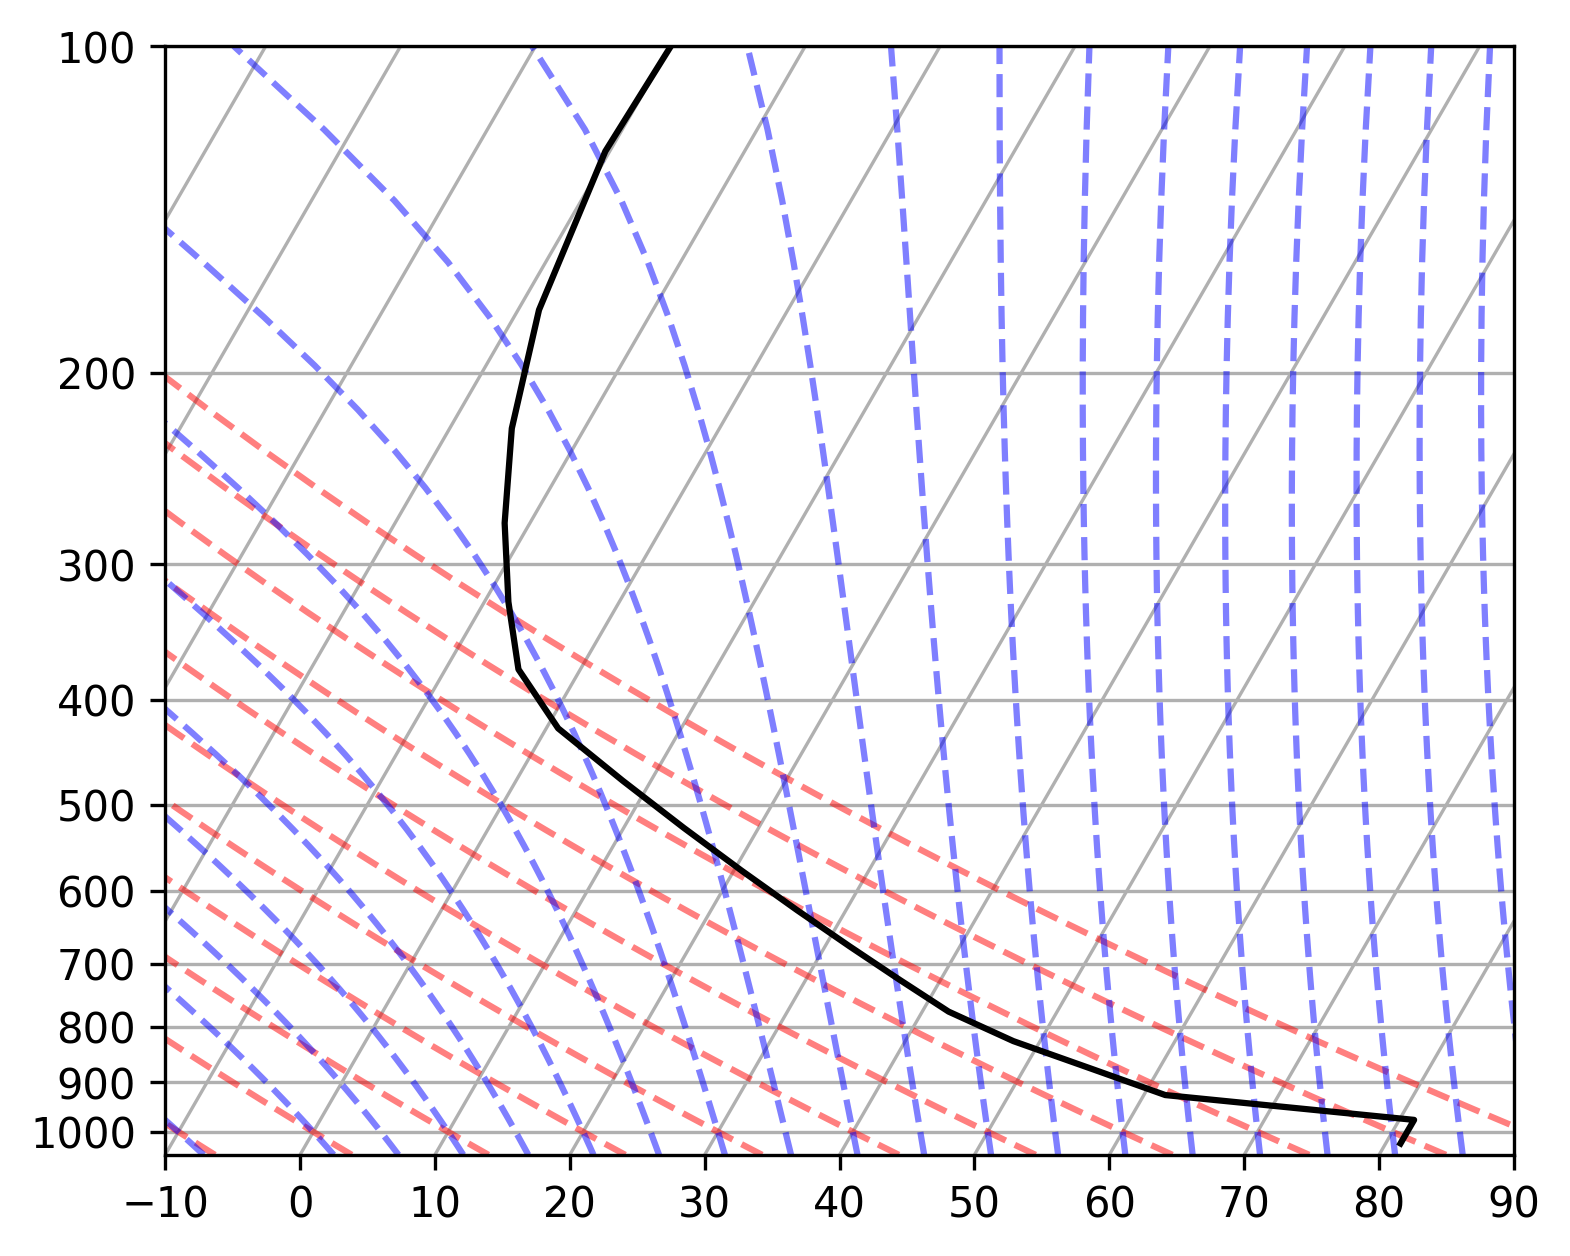

In [84]:
# skew t
fig = plt.figure(dpi=300)
skew = plots.SkewT(fig)
skew.plot(one_year_sim_ozone.mid_ps/100, (Ts_one_year_ozone[-1]-273.15), 'k')
skew.ax.set_xlim(-10, 90)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats();
fig.savefig('skew_t_with_ozone.png')

## Together

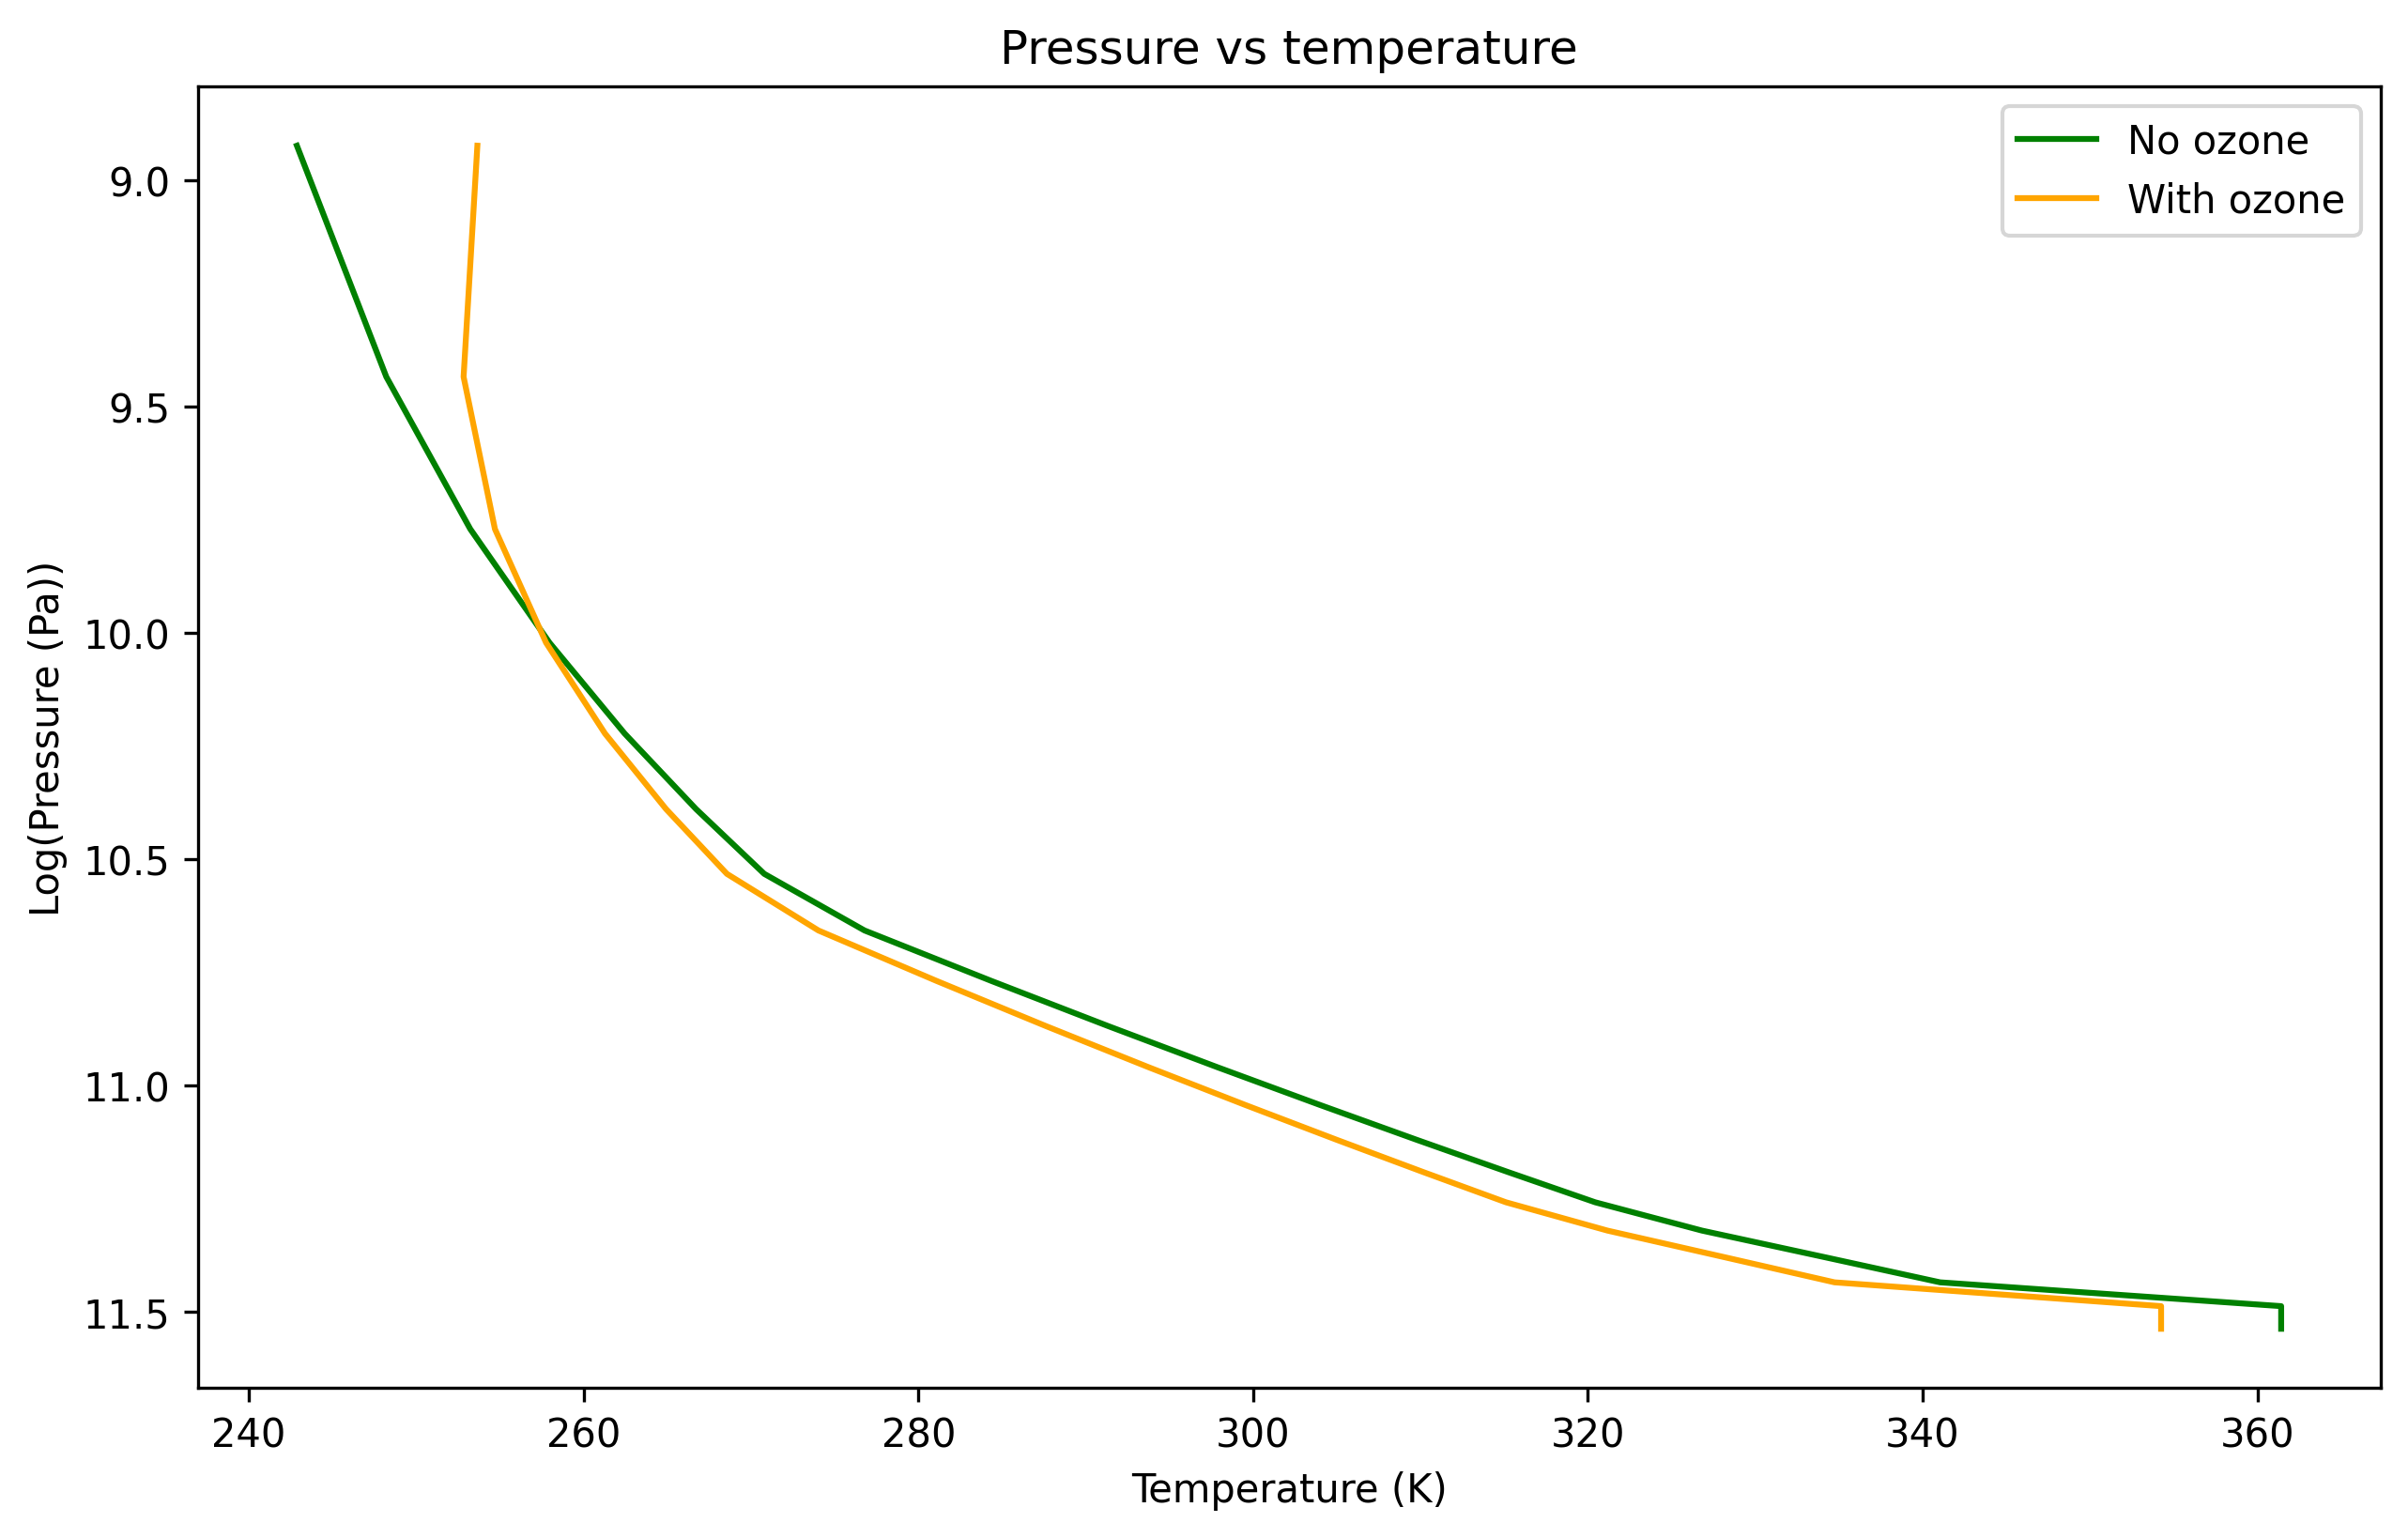

In [86]:
# plot vertical profile of temperature vs pressure height
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
ax.plot(Ts_one_year[-1][1:], np.log(one_year_sim.mid_ps[1:]), label='No ozone', c='green')
ax.plot(Ts_one_year_ozone[-1][1:], np.log(one_year_sim_ozone.mid_ps[1:]), label='With ozone', c='orange')
ax.plot()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Log(Pressure (Pa))')
ax.legend()
ax.invert_yaxis()
ax.set_title('Pressure vs temperature');
fig.savefig('p_v_t_together.png')

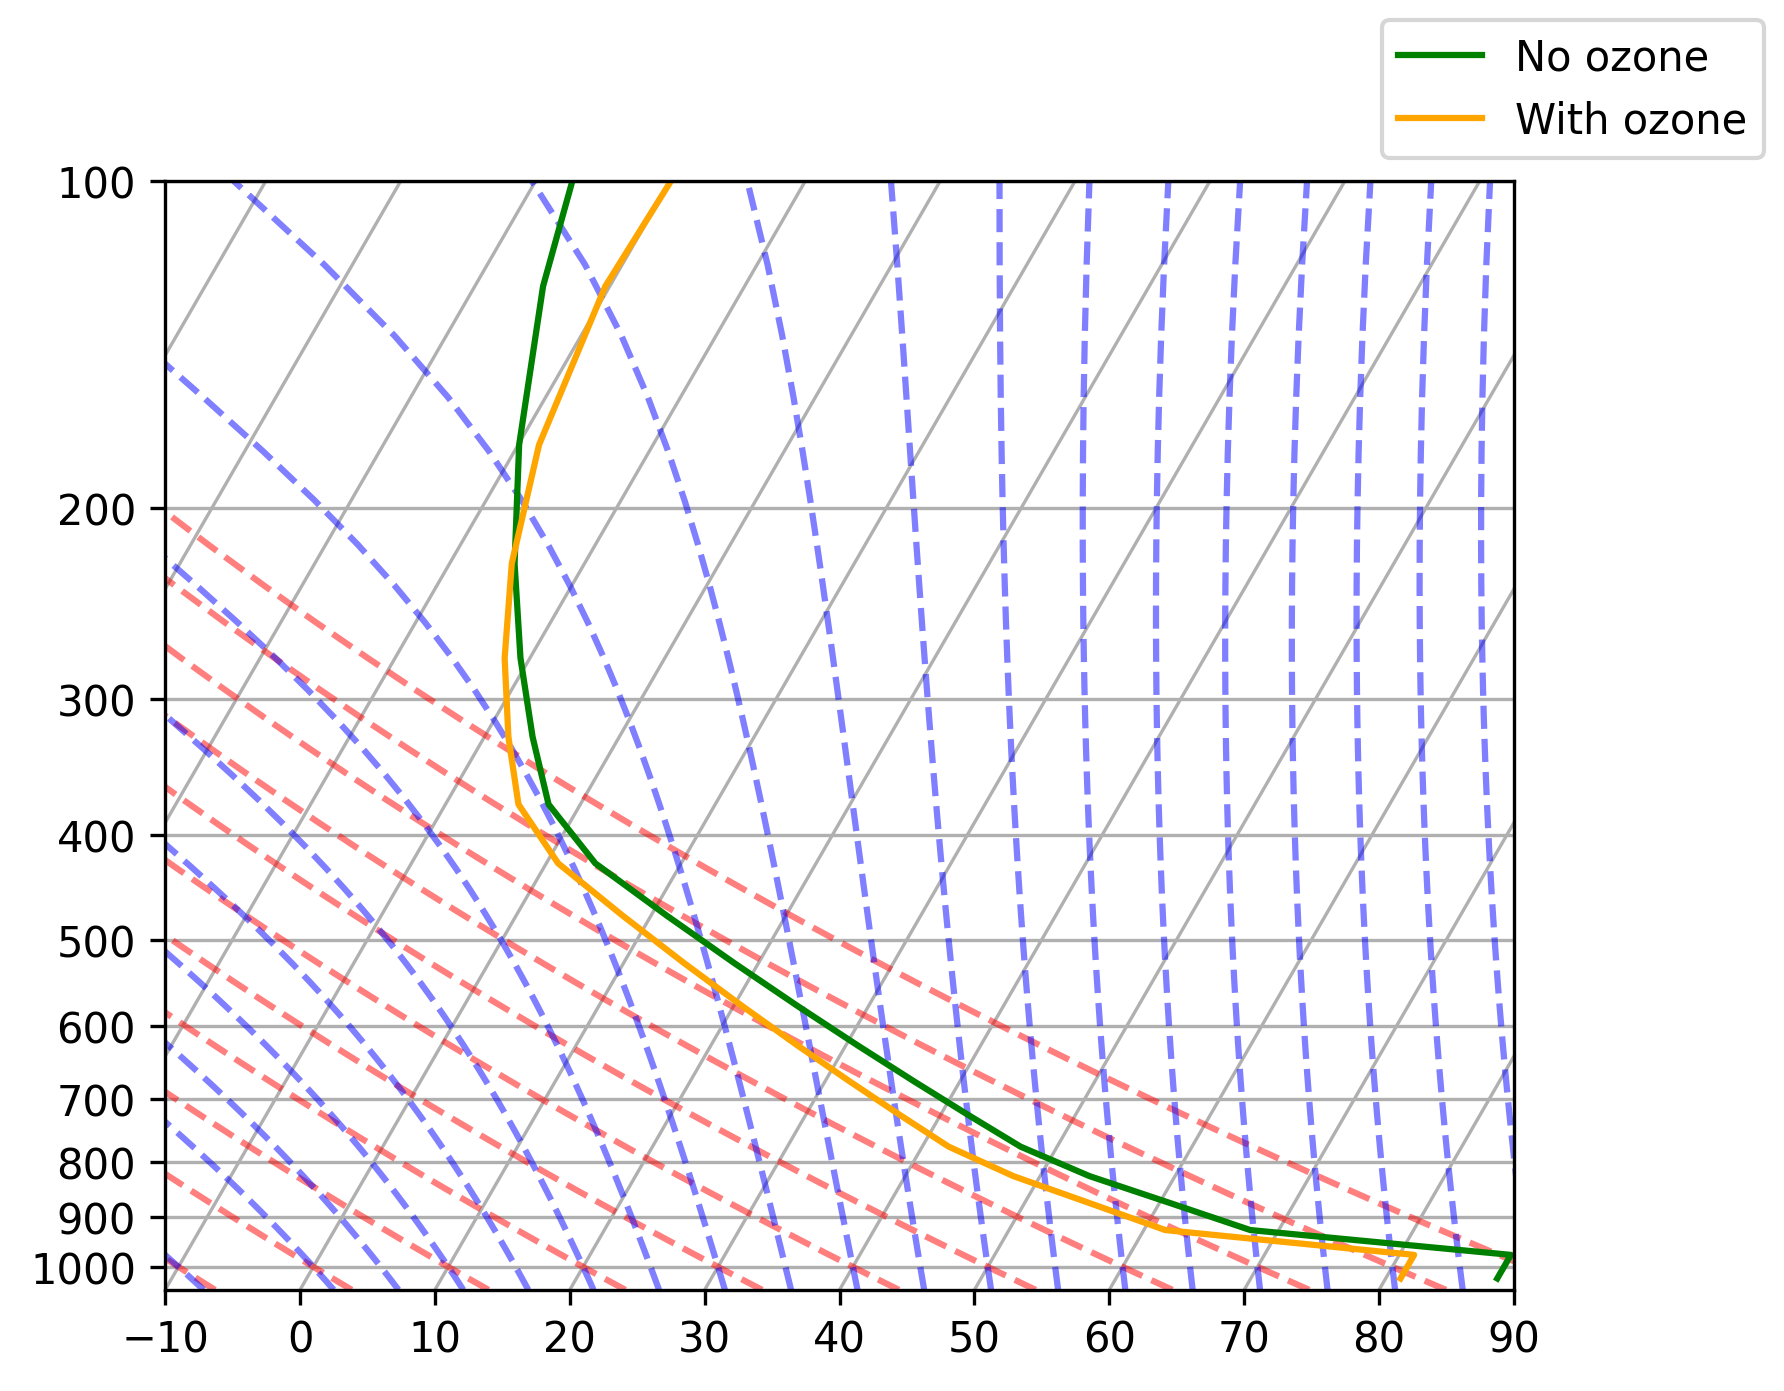

In [87]:
# skew t
fig = plt.figure(dpi=300)
skew = plots.SkewT(fig)
skew.plot(one_year_sim.mid_ps/100, (Ts_one_year[-1]-273.15), 'green', label='No ozone')
skew.plot(one_year_sim_ozone.mid_ps/100, (Ts_one_year_ozone[-1]-273.15), 'orange', label='With ozone')
skew.ax.set_xlim(-10, 90)
fig.legend()
skew.plot_dry_adiabats()
skew.plot_moist_adiabats();
fig.savefig('skew_t_together.png')

###**Analysis of results (with ozone):**
Based on the skew-t, the radiative equilibrium lapse rate indicates absolute instability up to 750hPa, conditional instability between roughly 750hPa to 380hPa, and absolute stability above 380hPa. The shortwave absorption just shifts the plot left, indicating a cooling effect. This makes sense because ozone prevents some shortwave radiation from penetrating the stratosphere, and less incoming radiation creates a cooler system.